# Handle spatial data 

In [1]:
import geopandas as gpd #Para archivos .shp 
import matplotlib.pyplot as plt #Para gráficar 
#Se define el tamaño de salidad de las gráficas

import numpy as np 
import pandas as pd

from shapely import wkt
import geopy.distance
from math import radians, cos, sin, asin, sqrt

from pandas.core.frame import DataFrame
from functools import reduce
import pyproj as pp
from pyproj import Proj


from pylab import rcParams 
rcParams['figure.figsize'] = 15,15

import warnings
warnings.filterwarnings('ignore')

## Handle spatial data of beneficiaries of non-contributory monetary transfers in Quito - MIES

In [2]:
#Database from MIES

# BDH and others pensions 
df_1 = pd.read_excel("https://info.inclusion.gob.ec/images/usuarios_externos/2023/bonos_pensiones_ago2023.xlsx", sheet_name= "PARTE 1 AGO2023",dtype={'dpa_prov': str})
df_2 = pd.read_excel("https://info.inclusion.gob.ec/images/usuarios_externos/2023/bonos_pensiones_ago2023.xlsx", sheet_name= "PARTE 2 AGO2023")
df_MIES = pd.concat([df_1, df_2], ignore_index=True)

df_ben = df_MIES.groupby(['dpa_desprov','beneficio'])['beneficio'].count().reset_index(name='Total_beneficiarios')
df_ben


,dpa_desprov,beneficio,Total_beneficiarios
0,AZUAY,BONO 1000 DIAS,1731
1,AZUAY,BONO DE DESARROLLO HUMANO,25914
2,AZUAY,BONO DE DESARROLLO HUMANO CON COMPONENTE VARIABLE,8903
3,AZUAY,BONO JOAQUIN GALLEGOS LARA,1280
4,AZUAY,PENSION MIS MEJORES AÑOS,14056
...,...,...,...
193,ZONA EN ESTUDIO,BONO DE DESARROLLO HUMANO CON COMPONENTE VARIABLE,427
194,ZONA EN ESTUDIO,PENSION MIS MEJORES AÑOS,423
195,ZONA EN ESTUDIO,PENSION PARA ADULTOS MAYORES,1
196,ZONA EN ESTUDIO,PENSION PARA PERSONAS CON DISCAPACIDAD,1


In [3]:
df_MIES_Quito = df_MIES[df_MIES['dpa_descan']=='DISTRITO METROPOLITANO DE QUITO']
df_MIES_Quito.head()

,zon_plan,uni_des_mi,dpa_prov,dpa_desprov,dpa_can,dpa_descan,dpa_par,dpa_despar,beneficio,edad,x,y,corte
320,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170162,GUANGOPOLO,PENSION MIS MEJORES AÑOS,94.0,-78.453238,-0.259818,ago 2023
424,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,83.0,-78.467887,-0.126370,ago 2023
461,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170111,GUAMANÍ,BONO JOAQUIN GALLEGOS LARA,95.0,-78.561417,-0.324848,ago 2023
985,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,76.0,-78.561565,-0.334326,ago 2023
1119,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,75.0,-78.571653,-0.330162,ago 2023


<Axes: >

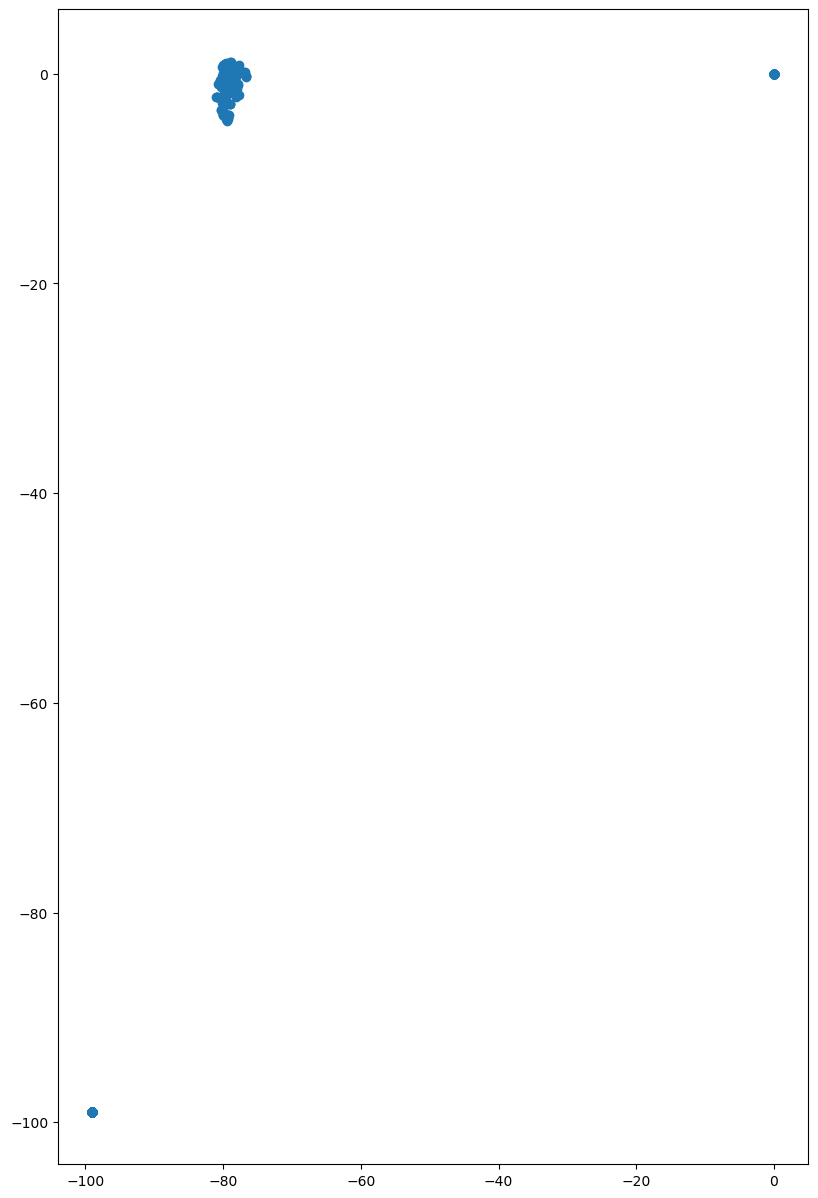

In [4]:
# Convert  MIES´s Database to spatial format "EPSG:4326"

df_MIES_Quito.dropna(subset=['x', 'y'], inplace= True)

df_MIES_gdf= gpd.GeoDataFrame(df_MIES_Quito, geometry= gpd.points_from_xy(df_MIES_Quito['x'],df_MIES_Quito['y']))
df_MIES_gdf['geometry'] = df_MIES_gdf['geometry'].astype(str).apply(wkt.loads)
gdf_hog = gpd.GeoDataFrame(df_MIES_gdf)

gdf_hog = gdf_hog.set_crs("EPSG:4326")
gdf_hog.plot()

MIES points have wrong geographical coor (points that are outside Quito), the following steps are performed:

1. The shapefile of Quito's Barrios is loaded and converted into the 4326 format (same geographic format as the MIES base)

In [67]:
df_barr= gpd.read_file("../data/Parroquia Quito/PARROQUIAS_REF.shp") #Se lee la base de datos .Shp
df_barr= df_barr.to_crs("EPSG:4326")

In [68]:
# Definir la lista de palabras
Urbanos = [
    "BELISARIO QUEVEDO",
    "COMITE DEL PUEBLO",
    "JIPIJAPA",
    "PONCEANO",
    "EL INCA",
    "CONCEPCION",
    "KENNEDY",
    "PUENGASI",
    "CARCELEN",
    "COTOCOLLAO",
    "LA ARGELIA",
    "QUITUMBE",
    "CENTRO HISTORICO",
    "EL CONDADO",
    "LA ECUATORIANA",
    "RUMIPAMBA",
    "CHILIBULO",
    "MAGDALENA",
    "LA FERROVIARIA",
    "SAN BARTOLO",
    "CHILLOGALLO",
    "GUAMANI",
    "LA LIBERTAD",
    "SAN JUAN",
    "CHIMBACALLE",
    "IÑAQUITO",
    "LA MENA",
    "SOLANDA",
    "COCHAPAMBA",
    "ITCHIMBIA",
    "MARISCAL SUCRE",
    "TURUBAMBA"
]




In [69]:
# Función para verificar si alguna de las palabras de la lista está presente en la columna 'barrios'
def es_urbano(barrio):
    for palabra in Urbanos:
        if palabra in barrio:
            return 'Urbano' 
    return 'No Urbano'

# Aplicar la función a la columna 'barrios' para crear la nueva columna 'Urbana'
df_barr['Urbana'] = df_barr['dpa_despar'].apply(lambda x: es_urbano(x))

df_barr= df_barr[df_barr['Urbana']=='Urbano']



2. Interception between beneficiaries of non-contributory monetary transfers and Quito's Barrios shapefile.

In [70]:
df_final = gpd.sjoin(gdf_hog,df_barr,how='left')
df_final.head(3)

,zon_plan,uni_des_mi,dpa_prov,dpa_desprov,dpa_can,dpa_descan,dpa_par,dpa_despar_left,beneficio,edad,x,y,corte,geometry,index_right,id,dpa_parroq,dpa_despar_right,Urbana
320,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170162,GUANGOPOLO,PENSION MIS MEJORES AÑOS,94.0,-78.453238,-0.259818,ago 2023,POINT (-78.45324 -0.25982),NaN,NaN,NaN,NaN,NaN
424,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,83.0,-78.467887,-0.126370,ago 2023,POINT (-78.46789 -0.12637),51.0,51.0,170105,COMITE DEL PUEBLO,Urbano
461,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170111,GUAMANÍ,BONO JOAQUIN GALLEGOS LARA,95.0,-78.561417,-0.324848,ago 2023,POINT (-78.56142 -0.32485),48.0,48.0,170111,GUAMANI,Urbano


3. The points that are outside of Quito are eliminated

<Axes: >

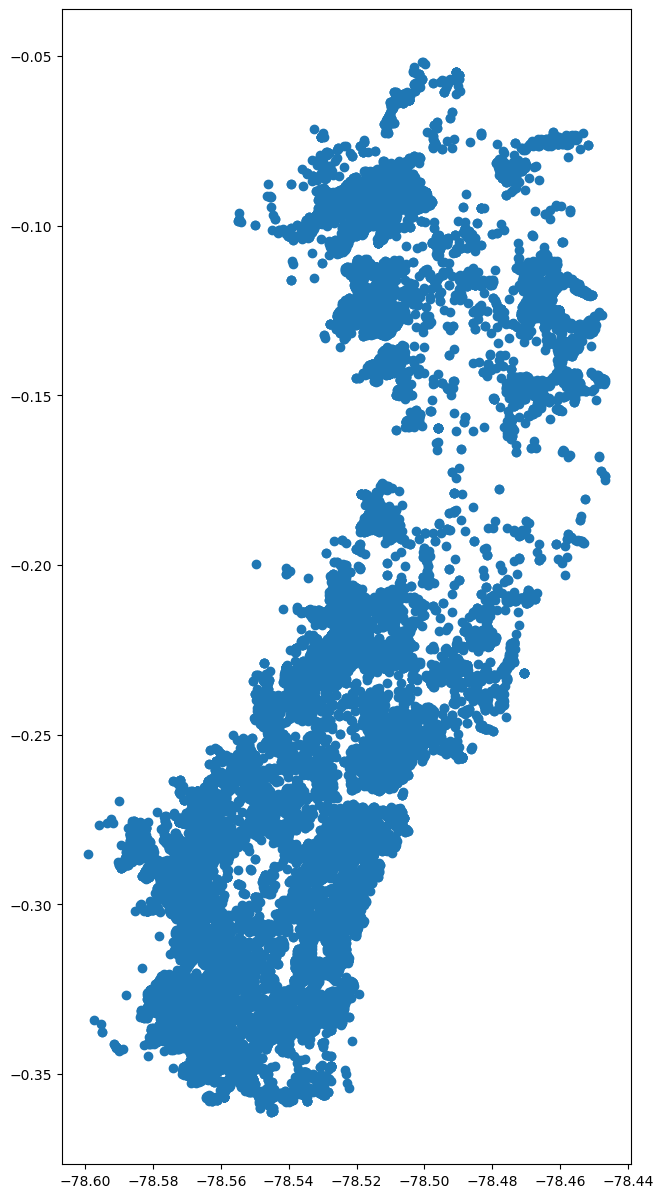

In [71]:
df_final.dropna(subset=['dpa_parroq'], inplace = True )
df_final.plot()

In [72]:
df_final

,zon_plan,uni_des_mi,dpa_prov,dpa_desprov,dpa_can,dpa_descan,dpa_par,dpa_despar_left,beneficio,edad,x,y,corte,geometry,index_right,id,dpa_parroq,dpa_despar_right,Urbana
424,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,83.0,-78.467887,-0.126370,ago 2023,POINT (-78.46789 -0.12637),51.0,51.0,170105,COMITE DEL PUEBLO,Urbano
461,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170111,GUAMANÍ,BONO JOAQUIN GALLEGOS LARA,95.0,-78.561417,-0.324848,ago 2023,POINT (-78.56142 -0.32485),48.0,48.0,170111,GUAMANI,Urbano
985,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,76.0,-78.561565,-0.334326,ago 2023,POINT (-78.56157 -0.33433),48.0,48.0,170111,GUAMANI,Urbano
1119,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,75.0,-78.571653,-0.330162,ago 2023,POINT (-78.57165 -0.33016),48.0,48.0,170111,GUAMANI,Urbano
1282,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,81.0,-78.501470,-0.090741,ago 2023,POINT (-78.50147 -0.09074),43.0,43.0,170110,EL CONDADO,Urbano
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441432,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,BONO DE DESARROLLO HUMANO,26.0,-78.535361,-0.268431,ago 2023,POINT (-78.53536 -0.26843),6.0,6.0,170131,SOLANDA,Urbano
1441467,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION TODA UNA VIDA,16.0,-78.568042,-0.292404,ago 2023,POINT (-78.56804 -0.29240),1.0,2.0,170118,LA ECUATORIANA,Urbano
1441556,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,BONO DE DESARROLLO HUMANO CON COMPONENTE VARIABLE,38.0,-78.507265,-0.224870,ago 2023,POINT (-78.50727 -0.22487),21.0,21.0,170103,CENTRO HISTORICO,Urbano
1441557,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION TODA UNA VIDA,17.0,-78.507265,-0.224870,ago 2023,POINT (-78.50727 -0.22487),21.0,21.0,170103,CENTRO HISTORICO,Urbano


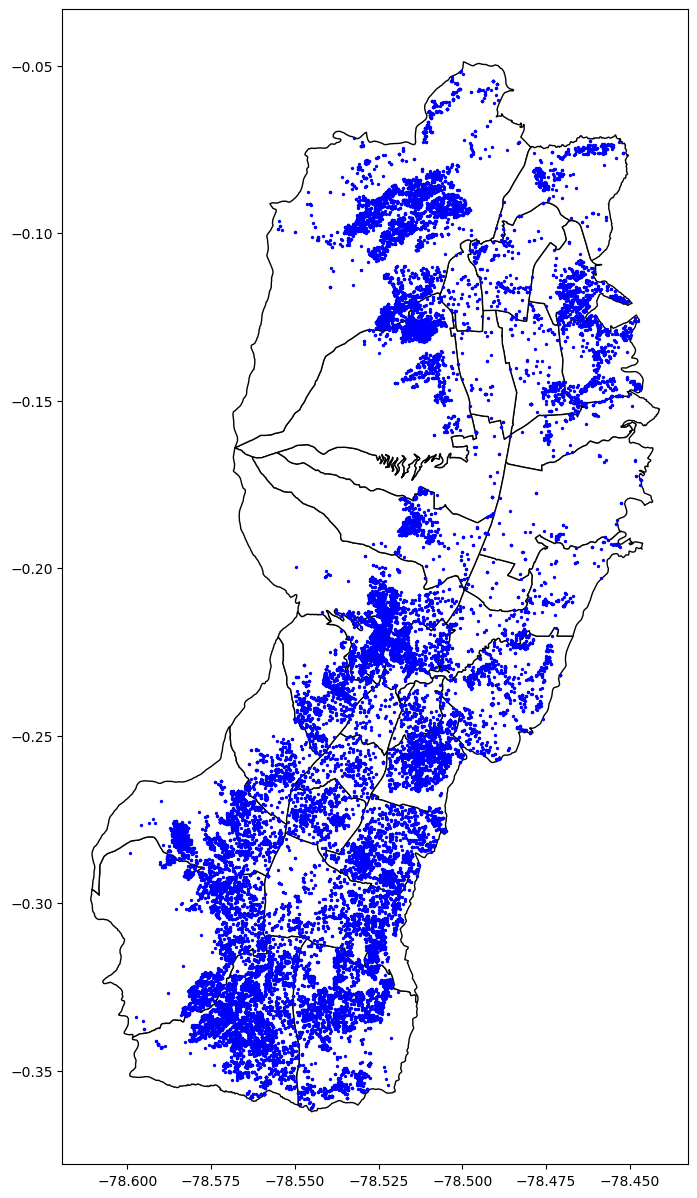

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_aspect('equal')
df_barr.plot(ax=ax, color='white', edgecolor='black')
df_final.plot(ax=ax, marker='o', color='blue', markersize=2)

plt.show()

In [74]:
df_final.groupby([ 'dpa_parroq', 'dpa_despar_right']).size().reset_index(name='counts')

,dpa_parroq,dpa_despar_right,counts
0,170101,BELISARIO QUEVEDO,624
1,170102,CARCELEN,356
2,170103,CENTRO HISTORICO,1314
3,170104,COCHAPAMBA,1453
4,170105,COMITE DEL PUEBLO,663
5,170106,COTOCOLLAO,66
6,170107,CHILIBULO,944
7,170108,CHILLOGALLO,2043
8,170109,CHIMBACALLE,206
9,170110,EL CONDADO,3571


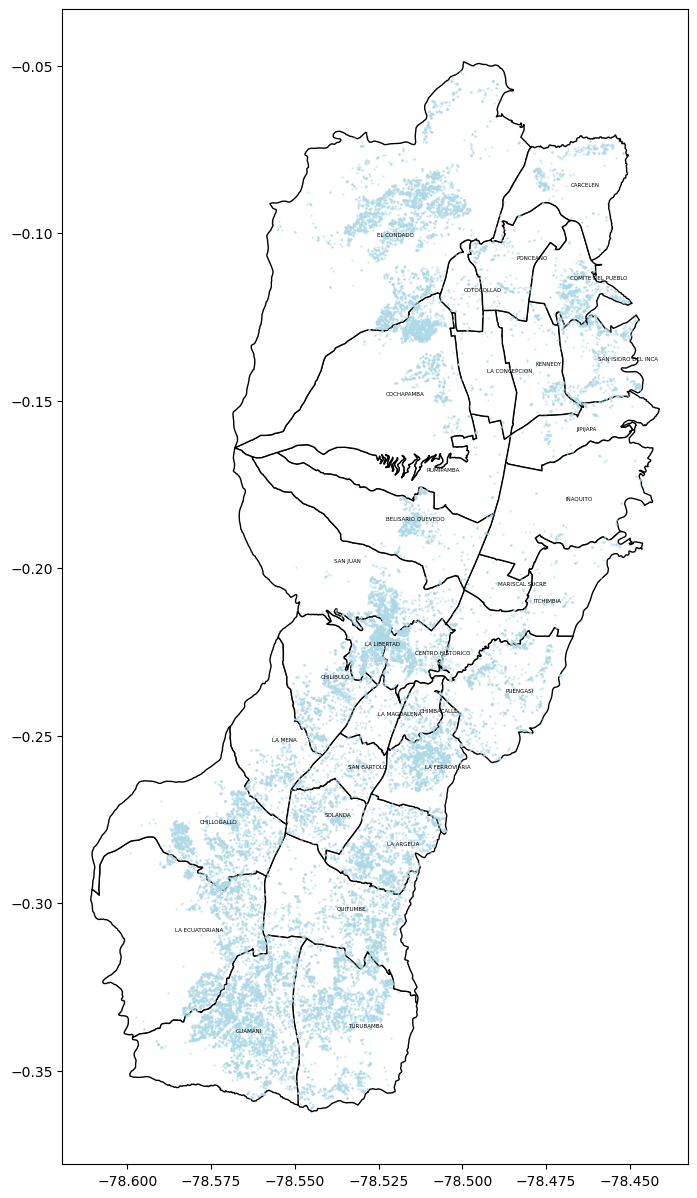

In [80]:
import matplotlib.pyplot as plt

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Establecer la relación de aspecto
ax.set_aspect('equal')

# Graficar los polígonos del DataFrame df_barr con color blanco y borde negro
df_barr.plot(ax=ax, color='white', edgecolor='black')

# Graficar los puntos del DataFrame df_final con marcadores azules, tamaño de marcador 1 y transparencia 0.5
df_final.plot(ax=ax, marker='o', color='lightblue', markersize=0.5, alpha=0.5)

# Agregar etiquetas a las zonas de df_barr
# Agregar etiquetas a las zonas de df_barr
for x, y, label in zip(df_barr.geometry.centroid.x, df_barr.geometry.centroid.y, df_barr['dpa_despar']):
    ax.annotate(label, (x, y), fontsize=4)

# Mostrar el mapa
plt.show()
